# Welcome to NGS Summer Training Project!

It will be covering the **"Statistics + R"** training content using **Cookie Cats** dataset.

Description: Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats.

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

But where should the gates be placed? Initially, the first gate was placed at level 30. In this project, we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.

In [ ]:
# To read the dataset into a data frame, run this cell
# https://drive.google.com/file/d/1kSAaGB0jU2X_6Q4hoRf7klDTOSQMCd_a/view

system("gdown --id 1kSAaGB0jU2X_6Q4hoRf7klDTOSQMCd_a")
cookie_cats = read.csv("cookie_cats.csv")

In [ ]:
# To learn more about the structure and variables of the dataset, use str() and head()
str(cookie_cats)
head(cookie_cats)

'data.frame':	90189 obs. of  5 variables:
 $ userid        : int  116 337 377 483 488 540 1066 1444 1574 1587 ...
 $ version       : chr  "gate_30" "gate_30" "gate_40" "gate_40" ...
 $ sum_gamerounds: int  3 38 165 1 179 187 0 2 108 153 ...
 $ retention_1   : chr  "False" "True" "True" "False" ...
 $ retention_7   : chr  "False" "False" "False" "False" ...


,userid,version,sum_gamerounds,retention_1,retention_7
,<int>,<chr>,<int>,<chr>,<chr>
1,116,gate_30,3,False,False
2,337,gate_30,38,True,False
3,377,gate_40,165,True,False
4,483,gate_40,1,False,False
5,488,gate_40,179,True,True
6,540,gate_40,187,True,True


# 1. **EDA** 

Let's perform an EDA on our data in order to learn more about its variables.

In [ ]:
install.packages("naniar")
install.packages("infer")
library(naniar)
library(ggplot2)
library(infer)
library(dplyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# First, let's check if the data contains any missing values
n_miss(cookie_cats)

# Let's check if there are any duplicates using duplicated()
sum(duplicated(cookie_cats))

[1] 0

[1] 0

In [ ]:
# Next, let's find the number of players who came back to play after 1 day or 7 days of installing using sum()
# Note: retention_1 and retention_7 are character variables not bool, find the appropriate function to convert them
cookie_cats$retention_1logical <- as.logical(cookie_cats$retention_1)
cookie_cats$retention_7logical <- as.logical(cookie_cats$retention_7)

print("Number of players after 1 day")
sum(cookie_cats$retention_1logical)
print("Number of players after 7 day")
sum(cookie_cats$retention_7logical)

[1] "Number of players after 1 day"


[1] 40153

[1] "Number of players after 7 day"


[1] 16781

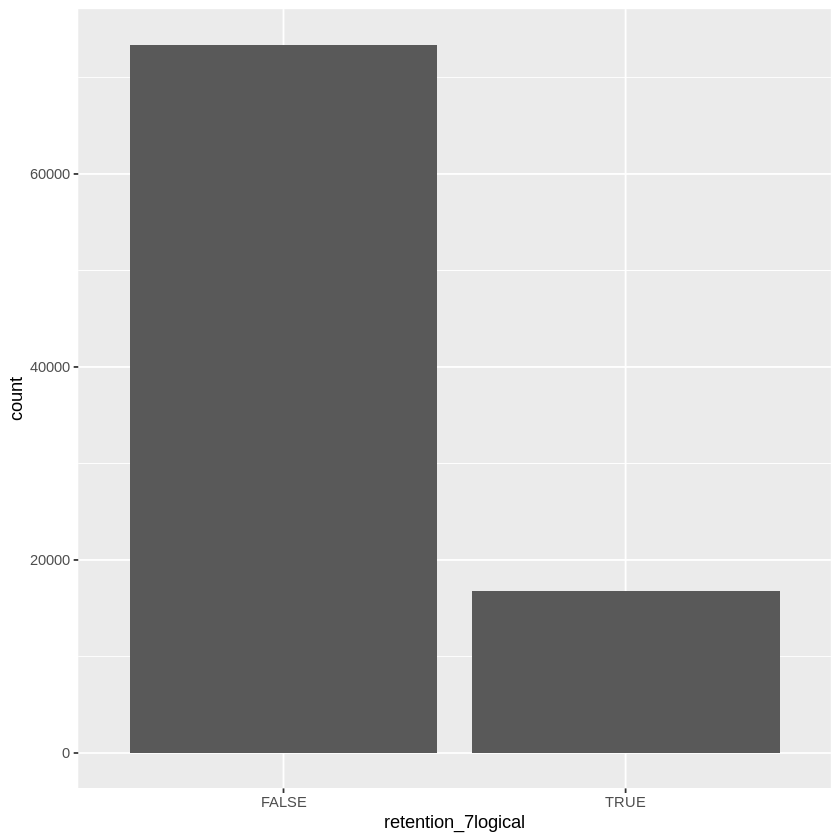

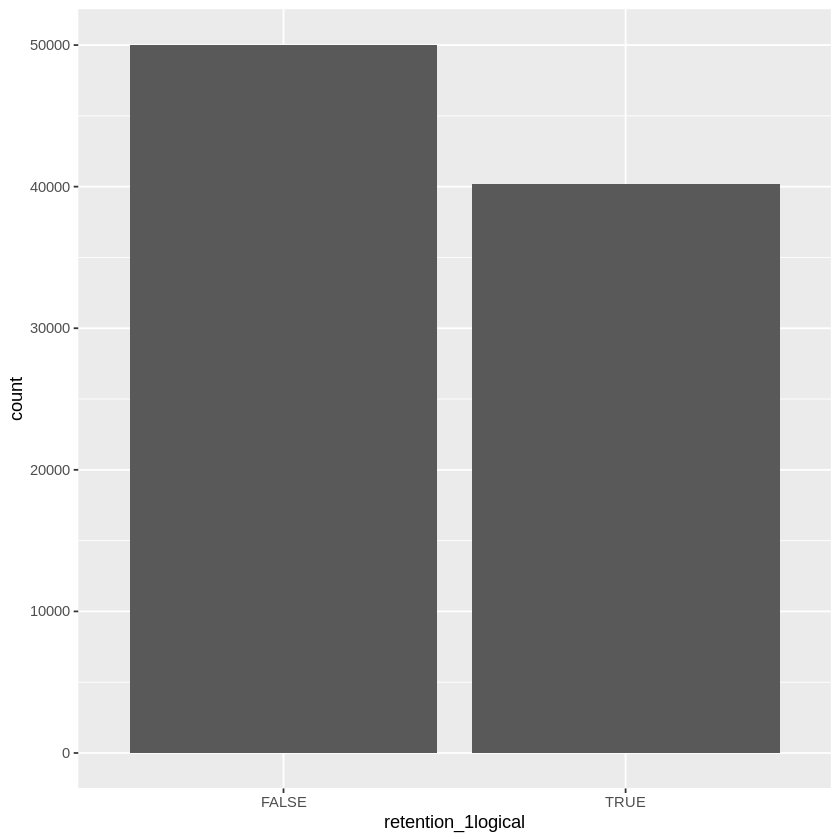

In [ ]:
# Let's now display retention_1 and retention_7 separately using a barplot
p1<-ggplot(cookie_cats, aes(retention_7logical)) + geom_bar()
p1
p7<-ggplot(cookie_cats, aes(retention_1logical)) + geom_bar()
p7

In [ ]:
# Finally, let's use summary() to find summaries regarding each variable
x <- summary(cookie_cats)
x

     userid          version          sum_gamerounds     retention_1       
 Min.   :    116   Length:90189       Min.   :    0.00   Length:90189      
 1st Qu.:2512230   Class :character   1st Qu.:    5.00   Class :character  
 Median :4995815   Mode  :character   Median :   16.00   Mode  :character  
 Mean   :4998412                      Mean   :   51.87                     
 3rd Qu.:7496452                      3rd Qu.:   51.00                     
 Max.   :9999861                      Max.   :49854.00                     
 retention_7        retention_1logical retention_7logical
 Length:90189       Mode :logical      Mode :logical     
 Class :character   FALSE:50036        FALSE:73408       
 Mode  :character   TRUE :40153        TRUE :16781       
                                                         
                                                         
                                                         

# 2.**The AB-test data**

The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

**userid** - a unique number that identifies each player.

**version** - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).

**sum_gamerounds** - the number of game rounds played by the player during the first 14 days after install.

**retention_1** - did the player come back and play **1 day** after installing?

**retention_7** - did the player come back and play **7 days** after installing?



# Problem Statement:

\begin{equation} H_{0} : p_{gate30} - p_{gate40} >= 0 \end{equation}

\begin{equation} H_{1} : p_{gate30} - p_{gate40} < 0 \end{equation}

When a player installed the game, he or she was randomly assigned to either **gate_30** or **gate_40**. As a sanity check, let's see if there are roughly the same number of players in each AB group.

In [ ]:
# Counting the number of players in each A/B group.(gate30 / gate40)
table(cookie_cats$version)


gate_30 gate_40 
  44700   45489 

## 2. The distribution of game rounds
<p><img src="https://assets.datacamp.com/production/project_184/img/mr_waffles_smiling.png" style="width:50px; float:right"> </p>
<p>It looks like there is roughly the same number of players in each group, nice!</p>
<p>The focus of this analysis will be on how the gate placement affects player retention, but just for fun: Let's plot the distribution of the number of game rounds players played during their first week playing the game.</p>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 12385 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


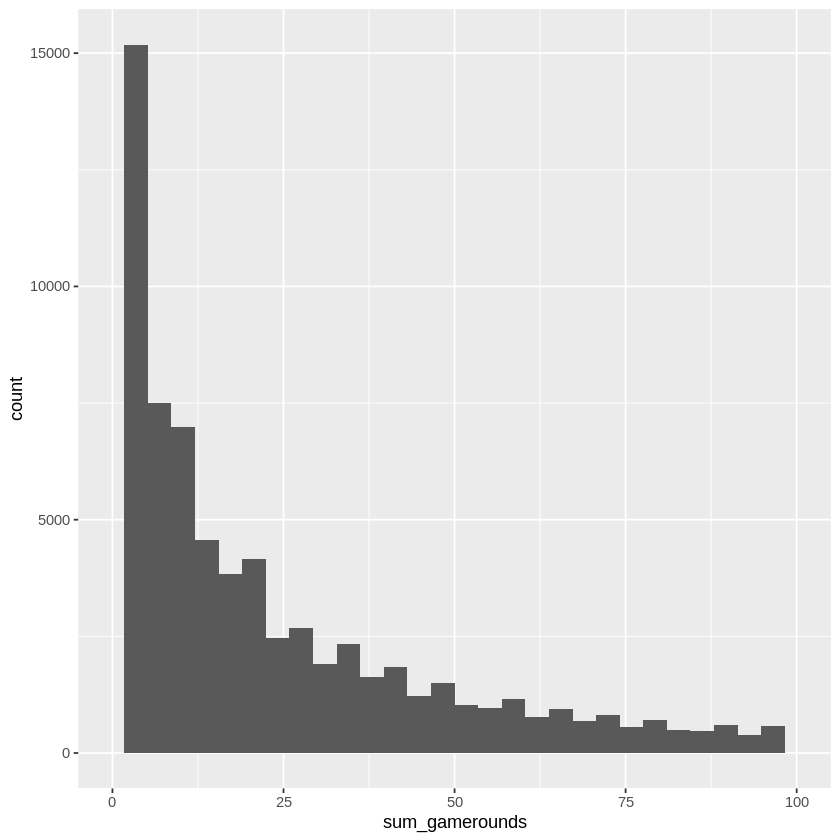

In [ ]:
# The distribution of game rounds
# Plotting the distribution of players that played 0 to 100 game rounds

m<- ggplot(cookie_cats,aes(x=sum_gamerounds))+geom_histogram()+xlim(0,100)
m

**3. Overall 1-day retention**

In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!



What we want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: The percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.



As a first step, **let's look at what 1-day and 7-day retention is overall.**

In [ ]:
# The % of users that came back the day(retention_1) after they installed
x <- sum(cookie_cats$retention_1logical)
z <- (x/90189)*100
z
# The % of users that came back a week(retention_7) after they installed
y <- sum(cookie_cats$retention_7logical)
q <- (y/90189)*100
q

[1] 44.52095

[1] 18.60648

So, a little less than half of the players come back one day after installing the game. 18 percent of the players come back 7 day after installing the game.

Now that we have a benchmark, let's look at how retention rates differs between the two A/B groups(gate30 /gate40).





In [ ]:
#Calculating the percentage of 1-day retention for each A/B group
print(aggregate(cookie_cats$retention_1logical, list(cookie_cats$version), FUN=mean))

#Calculating the percentage of 7-days retention for each A/B group
print(aggregate(cookie_cats$retention_7logical, list(cookie_cats$version), FUN=mean))

  Group.1         x
1 gate_30 0.4481879
2 gate_40 0.4422827
  Group.1         x
1 gate_30 0.1902013
2 gate_40 0.1820000


There was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control group when it was at level 30 (44.8%).

Again,a decrease in 7-day retention when the gate was moved to level 40 (18.2%) compared to the control group when it was at level 30 (19.8%).

It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

There are a couple of ways we can get at the certainty of these retention numbers. Here we will use **bootstrapping**.

# 4. A/B Testing: Bootstrapping 
**Definiton of Method**



We'll use **bootstrapping** for A/B testing. The basic idea of bootstrapping is that inference about a population from sample data (sample → population) can be modelled by resampling the sample data and performing inference about a sample from resampled data (resampled → sample). As the population is unknown, the true error in a sample statistic against its population value is unknown. In bootstrap-resamples, the 'population' is in fact the sample, and this is known; hence the quality of inference of the 'true' sample from resampled data (resampled → sample) is measurable. 

**Testing Steps:**

1-Creating 500 samples of dataset (bootstraping)

2-Calculating 1-day retentions for A/B groups

3-Plotting the bootstrap distributions

4-Calculating the observed differnce and the p_value 

5-making decisions to reject or fail to reject the null hypthesis 

6-repeat the previous steps on 7-day retention for A/B groups 

7-Evaluating results and making recommendation

In [ ]:
# Creating an list with bootstrapped means(NULL distribution) for group ( retention_1)
#install.packages("infer")
z <- cookie_cats %>%
  group_by(version) %>%
  summarize(prop_1=mean(retention_1=="True")) %>%
  summarize(diff(prop_1)) %>%
  pull()

cookies_cat_boot1 <- cookie_cats %>%
 specify(retention_1 ~ version ,success = "True") %>%
 hypothesize(null = "independence") %>%
 generate(reps = 500, type = "permute") %>%
 calculate(stat="diff in props", order = c("gate_30","gate_40"))

In [ ]:
#calculate the observed statistics (actual statistics)
cookies_cat_boot1 %>%
  summarize(mb=mean(z >=stat))

mb
<dbl>
0.028


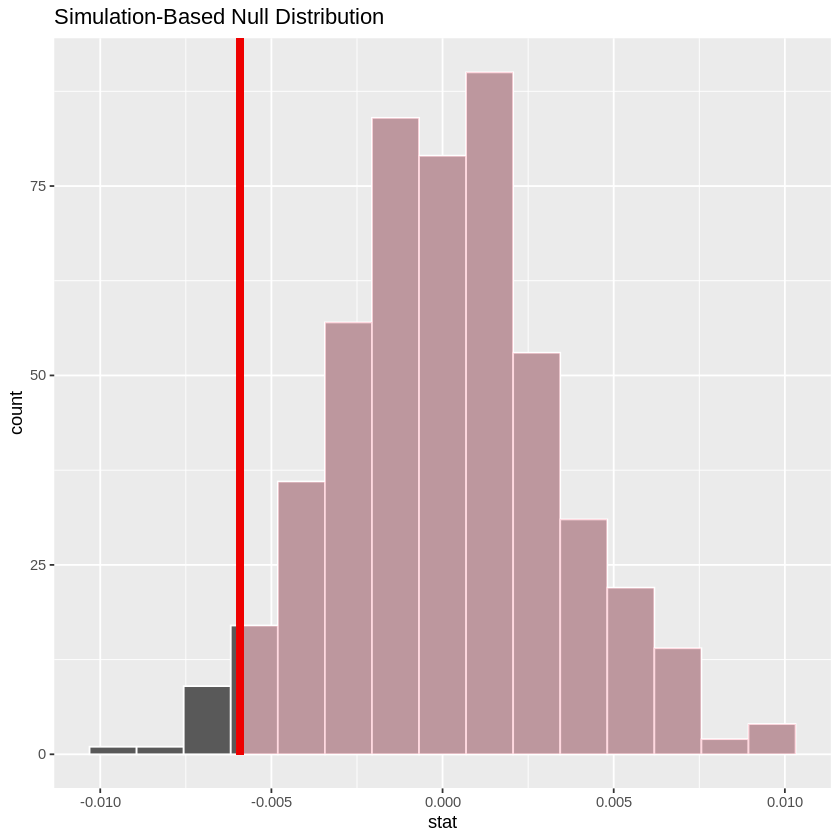

In [ ]:
#plot the null distrbiution (the list with bootstrapped props)
#then plot a line to represent the observed differnce
#Note: if you used the function shape_p_value(),set the value for the argument direction to "right"
cookies_cat_boot1 %>% visualize() +
  shade_p_value(obs_stat =z,direction="right")

In [ ]:
#calculate the p_value 
#Note: if you used the function get_p_value(),set the value for the argument direction to "right"
cookies_cat_boot1 %>% get_p_value(obs_stat = z,direction = "right")

p_value
<dbl>
0.972


The p_value for retention_1 is greater than 0.005 and that means we shouldn't move away from the null hypothesis (we fail to reject the null hypothesis ) ,that means the gate **should be kept at level 30.**



The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30.

But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.

**Let's start by calculating 7-day retention for the two AB-groups.**

In [ ]:
# Creating an list with bootstrapped props(NULL distribution) for group(retention_7)
z7 <- cookie_cats %>%
  group_by(version) %>%
  summarize(prop_1=mean(retention_7=="True")) %>%
  summarize(diff(prop_1)) %>%
  pull()

cookies_cat_boot7 <- cookie_cats %>%
 specify(retention_7 ~ version ,success = "True") %>%
 hypothesize(null = "independence") %>%
 generate(reps = 500, type = "permute") %>%
 calculate(stat="diff in props", order = c("gate_30","gate_40"))

In [ ]:
#calculate the observed statistics (actual statistics)
cookies_cat_boot7 %>%
  summarize(cq=mean(z7 >=stat))

cq
<dbl>
0.002


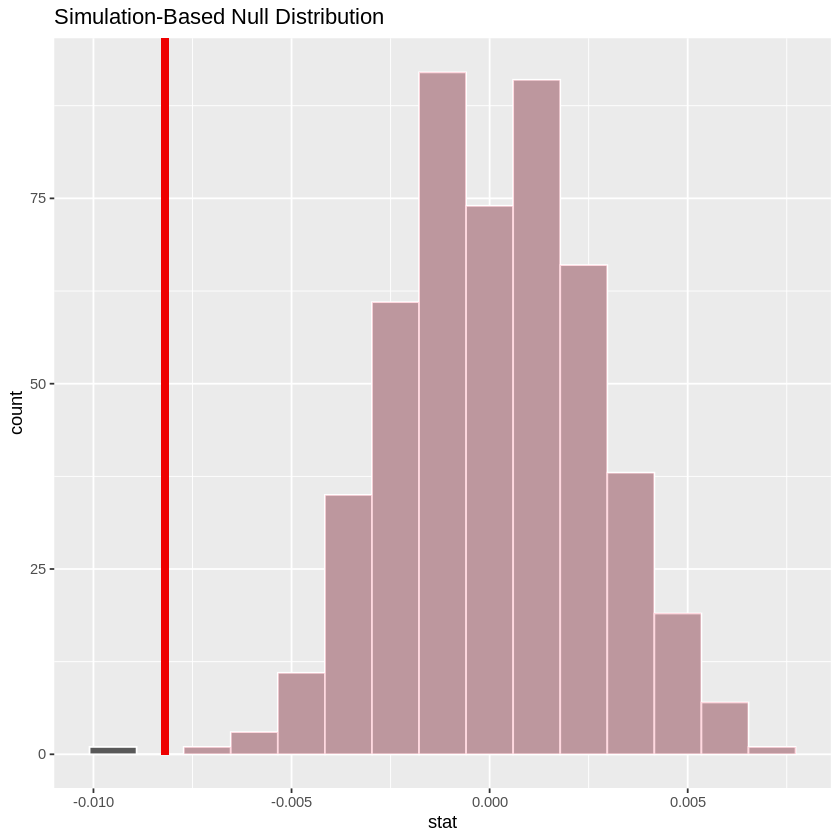

In [ ]:
#plot the null distrbiution (the list with bootstrapped props)
#then plot a line to represent the observed differnce 
#Note: if you used the function shape_p_value(),set the value for the argument direction to "right"
cookies_cat_boot7 %>% visualize() +
  shade_p_value(obs_stat = z7,direction="right")

In [ ]:
#calculating the p_value for retention_7
#Note: if you used the function get_p_value(),set the value for the argument direction to "right"
cookies_cat_boot7 %>% get_p_value(obs_stat = z7,direction = "right")

p_value
<dbl>
0.998



The bootstrap result tells us that there is strong evidence 99.8% probability that 7-day retention is higher when the gate is at level 30 than when it is at level 40.

The probability that 1-day retention is greater when the gate is at level 30: 97.0%       
The probability that 7-days retention is greater when the gate is at level 30: 100.0% 

# 5. The conclusion

If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics.
